Os incêndios florestais são um grave problema para a preservação das Florestas Tropicais. Compreender a frequência dos incêndios florestais em uma série temporal pode ajudar a tomar medidas para evitá-los.

Objetivo: Realizar a previsão de frequências de focos de incêndio para X dias.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from prophet import Prophet

## Adquirindo os dados

**Download do dataset**

Fonte: [Banco de Dados de Queimadas](https://basedosdados.org/dataset/f06f3cdc-b539-409b-b311-1ff8878fb8d9?raw_data_source=894ea9e3-c94a-4c99-a022-171ce01ac6ff)

In [4]:
!wget -O dataset.zip https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_todos_sats/focos_br_todos-sats_2024.zip

--2025-05-29 21:39:23--  https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_todos_sats/focos_br_todos-sats_2024.zip
Resolving dataserver-coids.inpe.br (dataserver-coids.inpe.br)... 150.163.218.16
Connecting to dataserver-coids.inpe.br (dataserver-coids.inpe.br)|150.163.218.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127158498 (121M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 121.27M  31.2MB/s    in 4.5s    

2025-05-29 21:39:27 (26.9 MB/s) - ‘dataset.zip’ saved [127158498/127158498]



**Descompactando os dados**

Necessário instalar o unzip com:

```bash
    sudo apt-get install zip unzip
```

In [3]:
!unzip dataset.zip -d dataset/

Archive:  dataset.zip
  inflating: dataset/tmp/focos_br_todos-sats_2024.csv  


## Análise dos dados

In [10]:
DATA_DIR = Path('dataset/tmp/focos_br_todos-sats_2024.csv')

df = pd.read_csv(DATA_DIR, parse_dates=['data_pas'])
df.head()

,latitude,longitude,data_pas,satelite,pais,estado,municipio,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
0,4.27167,-60.69947,2024-01-02 02:06:00,TERRA_M-M,Brasil,RORAIMA,PACARAIMA,Amazônia,7.0,0.00,1.00,0,14.4
1,-9.55578,-35.70564,2024-01-02 04:08:00,NPP-375D,Brasil,ALAGOAS,MACEIÓ,Mata Atlântica,-999.0,0.00,1.00,0,0.4
2,-9.55515,-35.71013,2024-01-02 04:08:00,NPP-375D,Brasil,ALAGOAS,MACEIÓ,Mata Atlântica,-999.0,0.00,1.00,0,2.7
3,-7.36323,-39.94515,2024-01-02 04:08:00,NPP-375D,Brasil,PERNAMBUCO,BODOCÓ,Caatinga,7.0,1.32,0.54,0,2.1
4,-3.51178,-40.13655,2024-01-02 04:06:00,NPP-375D,Brasil,CEARÁ,SANTANA DO ACARAÚ,Caatinga,3.0,3.38,0.00,0,1.0


In [11]:
# Cria um novo campo apenas com a data, sem a hora
df['data'] = df['data_pas'].dt.date

In [16]:
df_occurrences = df.groupby('data').size().reset_index(name='ocorrencias')
df_occurrences.head()

,data,ocorrencias
0,2024-01-01,1041
1,2024-01-02,1475
2,2024-01-03,3168
3,2024-01-04,5188
4,2024-01-05,4992


### Visualizando os dados

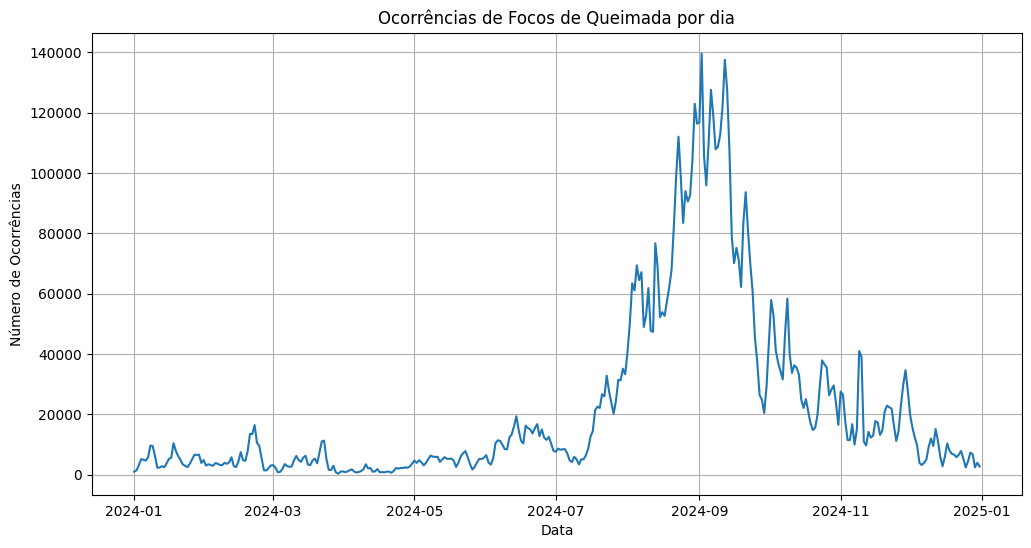

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df_occurrences['data'], df_occurrences['ocorrencias'])
plt.title('Ocorrências de Focos de Queimada por dia')
plt.xlabel('Data')
plt.ylabel('Número de Ocorrências')
plt.grid(True)